In [31]:
import io, zipfile
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import contextily as ctx

In [32]:
BASE = Path("/users/eleves-b/2023/wenrui.dai/Desktop/environment/Helsinki/")
GPKG = BASE / "TD_414_diff.gpkg"
GTFS = BASE / "GTFS.zip"
CRS_PLOT = "EPSG:3857"
BASEMAP = ctx.providers.CartoDB.PositronNoLabels

In [33]:
#Select color
ZERO = "#ADADAD"
RED5 = ['#FCE1E1','#F2B1B1','#FC4242','#8F0606','#2E0000'] 
BLUE5= ['#0B1F51','#22479D','#4D7BBD','#8FBFE0','#C7E0F3']

ROUTE_STYLE = {
    1:   {"color": "#7B1FA2", "lw": 1.2, "label": "Subway"},   
    0:   {"color": "#2E7D32", "lw": 1.2, "label": "Tram/LRT"}, 
    109: {"color": "#FF8F00", "lw": 1.2, "label": "Rail"},     
}

MODE_TO_RT = {"subway": 1, "tram": 0, "rail": 109}

In [34]:
#Read GPKG file
gdf = gpd.read_file(GPKG)
if gdf.crs is None:
    raise ValueError("GPKG 没有 CRS，请先为数据设置正确的坐标系。")
gdf = gdf.to_crs(CRS_PLOT)

NEEDED = [
    "total_emission_m","total_emission_n",
    "total_emission_subway_m","total_emission_tram_m","total_emission_rail_m","total_emission_bus_m",
    "total_emission_subway_n","total_emission_tram_n","total_emission_rail_n","total_emission_bus_n",
    "emission_diff",
]
for c in NEEDED:
    if c in gdf.columns:
        gdf[c] = pd.to_numeric(gdf[c], errors="coerce")

for mode in ("subway","tram","rail","bus"):
    diff_col = f"emission_diff_{mode}"
    m_col, n_col = f"total_emission_{mode}_m", f"total_emission_{mode}_n"
    if diff_col not in gdf.columns and (m_col in gdf.columns and n_col in gdf.columns):
        gdf[diff_col] = gdf[m_col] - gdf[n_col]

In [35]:
#Read GTFS file and built road network
def read_from_zip(zip_path, name, usecols=None, dtype=str):
    with zipfile.ZipFile(zip_path) as z:
        with z.open(name) as f:
            return pd.read_csv(io.TextIOWrapper(f, encoding="utf-8"),
                               dtype=dtype, usecols=usecols)

routes = read_from_zip(GTFS, "routes.txt",
                       usecols=["route_id","route_type","route_short_name","route_long_name"])
trips  = read_from_zip(GTFS, "trips.txt",
                       usecols=["route_id","trip_id","shape_id"])
shapes = read_from_zip(GTFS, "shapes.txt",
                       usecols=["shape_id","shape_pt_lat","shape_pt_lon","shape_pt_sequence"])

routes["route_type"] = pd.to_numeric(routes["route_type"], errors="coerce").astype("Int64")
trips = trips.dropna(subset=["shape_id"])
shapes["shape_pt_sequence"] = pd.to_numeric(shapes["shape_pt_sequence"], errors="coerce")
shapes["shape_pt_lat"] = pd.to_numeric(shapes["shape_pt_lat"], errors="coerce")
shapes["shape_pt_lon"] = pd.to_numeric(shapes["shape_pt_lon"], errors="coerce")

RT_KEEP = {0: "Tram/LRT", 1: "Subway", 109: "Rail"}
rt = trips.merge(routes[["route_id","route_type"]], on="route_id", how="left")
rt = rt[rt["route_type"].isin(RT_KEEP.keys())].dropna(subset=["shape_id"])
shape_ids = set(rt["shape_id"].unique())

shapes_sel = shapes[shapes["shape_id"].isin(shape_ids)].dropna(
    subset=["shape_pt_lat","shape_pt_lon","shape_pt_sequence"]
).sort_values(["shape_id","shape_pt_sequence"])

lines = []
for sid, grp in shapes_sel.groupby("shape_id", sort=False):
    coords = list(zip(grp["shape_pt_lon"].values, grp["shape_pt_lat"].values))
    if len(coords) >= 2:
        lines.append({"shape_id": sid, "geometry": LineString(coords)})

g_shapes = gpd.GeoDataFrame(lines, crs="EPSG:4326")
g_shapes = g_shapes.merge(rt[["shape_id","route_type"]].drop_duplicates(),
                          on="shape_id", how="left")
g_shapes = g_shapes.to_crs(CRS_PLOT)

In [36]:
# === HSL fare zones (A/B/C/D) ===
ZONES_PATH = BASE / "HSL_zones.gpkg"
zones_diss = None
if ZONES_PATH.exists():
    try:
        import fiona
        try:
            zones_raw = gpd.read_file(ZONES_PATH)
        except Exception:
            lyr = fiona.listlayers(ZONES_PATH)[0]
            zones_raw = gpd.read_file(ZONES_PATH, layer=lyr)
        zones_raw = zones_raw.to_crs(CRS_PLOT)

        cand_cols = ["zone","vyohyke","vyöhyke","ZONE","Vyohyke","vyohykekirjain",
                     "vyohykekoodi","vyöhyke_kirjain","vyöhyke_koodi","letter","Letter"]
        col = next((c for c in cand_cols if c in zones_raw.columns), None)
        if col is None:
            for c in zones_raw.columns:
                if zones_raw[c].dtype == object:
                    s = zones_raw[c].astype(str).str.upper().str.extract(r'([ABCD])')[0]
                    if s.notna().any():
                        zones_raw["ZONE_LBL"] = s; col = "ZONE_LBL"; break
        else:
            zones_raw["ZONE_LBL"] = zones_raw[col].astype(str).str.upper().str.extract(r'([ABCD])')[0]
        if "ZONE_LBL" in zones_raw.columns:
            zones_diss = zones_raw.dissolve(by="ZONE_LBL").reset_index()
    except Exception as e:
        print("⚠️ 读取 HSL_zones.GPKG 失败：", e)


In [37]:
#Define function
BINS   = [0, 50, 100, 150, 200, float("inf")]
LABELS = ["0 ~ 50", "50 ~ 100", "100 ~ 150", "150 ~ 200", "≥ 200"]

NEG_BINS   = [-float("inf"), -100, -75, -50, -25, 0]
NEG_LABELS = ["≤ -100","-100 ~ -75","-75 ~ -50","-50 ~ -25","-25 ~ 0"]
POS_BINS   = [0, 25, 50, 75, 100, float("inf")]
POS_LABELS = ["0 ~ 25","25 ~ 50","50 ~ 75","75 ~ 100","≥ 100"]

def _extent(ax, g, pad_frac=0.035, min_pad=800):
    xmin, ymin, xmax, ymax = g.total_bounds
    w, h = (xmax - xmin), (ymax - ymin)
    dx = max(w * pad_frac, min_pad)
    dy = max(h * pad_frac, min_pad)
    ax.set_xlim(xmin - dx, xmax + dx)
    ax.set_ylim(ymin - dy, ymax + dy)
    ax.set_aspect(1.0, adjustable="datalim")

def _add_basemap(ax):
    ctx.add_basemap(ax, source=BASEMAP, crs=CRS_PLOT, alpha=1.0, attribution_size=6)

def classify_total(df, col, bins, labels):
    out = df[[col, "geometry"]].copy()
    s = pd.to_numeric(out[col], errors="coerce").fillna(0)
    out["_is_zero"] = (s == 0)
    out["_is_pos"]  = (s > 0)
    out["class"] = None
    out.loc[out["_is_zero"], "class"] = "Zero"
    out.loc[out["_is_pos"],  "class"] = pd.cut(
        s[out["_is_pos"]],
        bins=bins, labels=labels, right=True, include_lowest=False
    ).astype(str)
    classes_order = ["Zero"] + list(labels)
    out["class"] = pd.Categorical(out["class"], categories=classes_order, ordered=True)
    return out

def classify_diff(df, col, bins_neg, bins_pos, labels_neg, labels_pos):
    s = pd.to_numeric(df[col], errors="coerce")
    out = df[[col, "geometry"]].copy()
    out["class_neg"] = pd.cut(s, bins=bins_neg, labels=labels_neg, right=True, include_lowest=True)
    out["class_pos"] = pd.cut(s, bins=bins_pos, labels=labels_pos, right=True, include_lowest=False)
    out["is_zero"] = (s == 0)
    return out

def plot_choropleth_total(ax, cls_gdf, red_colors=RED5):
    color_map = {"Zero": ZERO}
    for lab, col in zip(cls_gdf["class"].cat.categories[1:], red_colors):
        color_map[str(lab)] = col
    for lab in cls_gdf["class"].cat.categories:
        sub = cls_gdf[cls_gdf["class"] == lab]
        if len(sub):
            sub.plot(ax=ax, color=color_map[str(lab)], edgecolor="white", linewidth=0.05, zorder=3)

def plot_choropleth_diff(ax, cls_gdf, blue_colors=BLUE5, red_colors=RED5):
    if "class_neg" in cls_gdf:
        for lab, col in zip(cls_gdf["class_neg"].cat.categories, blue_colors):
            sub = cls_gdf[cls_gdf["class_neg"] == lab]
            if len(sub):
                sub.plot(ax=ax, color=col, edgecolor="white", linewidth=0.05, zorder=3)
    z = cls_gdf[cls_gdf["is_zero"] == True]
    if len(z):
        z.plot(ax=ax, color=ZERO, edgecolor="white", linewidth=0.05, zorder=3)
    if "class_pos" in cls_gdf:
        for lab, col in zip(cls_gdf["class_pos"].cat.categories, red_colors):
            sub = cls_gdf[cls_gdf["class_pos"] == lab]
            if len(sub):
                sub.plot(ax=ax, color=col, edgecolor="white", linewidth=0.05, zorder=3)

def overlay_routes(ax, mode):
    if mode in MODE_TO_RT:
        rtype = MODE_TO_RT[mode]
        st = ROUTE_STYLE[rtype]
        sub = g_shapes[g_shapes["route_type"] == rtype]
        if len(sub):
            sub.plot(ax=ax, color=st["color"], linewidth=st["lw"], alpha=0.6, zorder=6, linestyle=st.get("ls", "-"),
            )
    elif mode == "bus":
        for rtype in (1, 0, 109):
            st = ROUTE_STYLE[rtype]
            sub = g_shapes[g_shapes["route_type"] == rtype]
            if len(sub):
                sub.plot(ax=ax, color=st["color"], linewidth=max(0.8, st["lw"] * 0.5),
                         alpha=0.25, zorder=6, linestyle=st.get("ls", "-"),
                )
                
def overlay_hsl_zones(ax, show_labels=True):
    """把 HSL 四区边界裁剪到当前子图视域，并叠加虚线边界与 A/B/C/D 标签。"""
    if zones_diss is None or zones_diss.empty:
        return

    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    view_box = gpd.GeoDataFrame(geometry=[box(min(x0,x1), min(y0,y1), max(x0,x1), max(y0,y1))],
                                crs=CRS_PLOT)

    zclip = gpd.clip(zones_diss, view_box)

    zclip.boundary.plot(ax=ax, color="#404040", linewidth=0.8,
                        linestyle="--", alpha=0.7, zorder=5)

    if show_labels and not zclip.empty:
        parts = zclip.explode(ignore_index=True)
        parts["__area__"] = parts.geometry.area
        biggest = parts.sort_values("__area__", ascending=False).drop_duplicates("ZONE_LBL")
        for _, row in biggest.iterrows():
            try:
                x, y = row.geometry.representative_point().coords[0]
                ax.text(x, y, row["ZONE_LBL"], ha="center", va="center",
                        fontsize=11, weight="bold", color="#303030", alpha=0.85, zorder=7,
                        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.55))
            except Exception:
                pass


In [38]:
#Legend
def handles_total_legend():
    h = [Patch(facecolor=ZERO, edgecolor="white", label="Zero")]
    for lab, col in zip(LABELS, RED5):
        h.append(Patch(facecolor=col, edgecolor="white", label=str(lab)))
    return h

def handles_diff_legend():
    h = []
    for lab, col in zip(NEG_LABELS, BLUE5):
        h.append(Patch(facecolor=col, edgecolor="white", label=str(lab)))
    h.append(Patch(facecolor=ZERO, edgecolor="white", label="0"))
    for lab, col in zip(POS_LABELS, RED5):
        h.append(Patch(facecolor=col, edgecolor="white", label=str(lab)))
    return h

def handles_route_legend_for_mode(mode):
    if mode == "bus":
        return [
            Line2D([0],[0], color=ROUTE_STYLE[1]["color"], lw=max(0.8, ROUTE_STYLE[1]["lw"]*0.6), alpha=0.35, label="Subway"),
            Line2D([0],[0], color=ROUTE_STYLE[0]["color"], lw=max(0.8, ROUTE_STYLE[0]["lw"]*0.6), alpha=0.35, label="Tram/LRT"),
            Line2D([0],[0], color=ROUTE_STYLE[109]["color"], lw=max(0.8, ROUTE_STYLE[109]["lw"]*0.6), alpha=0.35, label="Rail"),
        ]
    else:
        rtype = MODE_TO_RT[mode]
        st = ROUTE_STYLE[rtype]
        return [Line2D([0],[0], color=st["color"], lw=st["lw"], label=st["label"])]


In [39]:
#Plot
def plot_total_single(col, title):
    fig, ax = plt.subplots(figsize=(10,10))
    _extent(ax, gdf, pad_frac=0.05); _add_basemap(ax)
    cls = classify_total(gdf, col, bins=BINS, labels=LABELS)
    plot_choropleth_total(ax, cls)
    overlay_hsl_zones(ax) 
    leg = ax.legend(handles=handles_total_legend(), title="Emission", loc="upper left",
                frameon=True, fontsize=9, title_fontsize=10)
    leg._legend_box.align = "left"
    ax.set_axis_off(); ax.set_title(title, fontsize=13)
    plt.tight_layout(); plt.show()

def plot_total_by_mode(suffix, title):
    modes = [("subway", f"total_emission_subway_{suffix}"),
             ("tram",   f"total_emission_tram_{suffix}"),
             ("rail",   f"total_emission_rail_{suffix}"),
             ("bus",    f"total_emission_bus_{suffix}")]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                             gridspec_kw={'hspace': 0.06, 'wspace': 0.10})
    axes = axes.ravel()

    for i, (ax, (mode, col)) in enumerate(zip(axes, modes)):
        _extent(ax, gdf, pad_frac=0.035); _add_basemap(ax)
        cls = classify_total(gdf, col, bins=BINS, labels=LABELS)
        plot_choropleth_total(ax, cls)
        overlay_hsl_zones(ax)
        overlay_routes(ax, mode)
        ax.legend(handles=handles_route_legend_for_mode(mode),
                  loc="lower right", frameon=True, fontsize=9, title=None)
        title_pad = 6 if i < 2 else 8
        ax.set_axis_off(); ax.set_title(f"{title} — {mode}", fontsize=12, pad=title_pad)

    fig.subplots_adjust(top=0.9)
    fig.legend(handles=handles_total_legend(), title="Emission",
               loc="upper center", bbox_to_anchor=(0.5, 0.99),
               ncol=6, frameon=True, fontsize=10, title_fontsize=11,
               borderaxespad=0.0)

    plt.show()

def plot_diff_single(col, title):
    fig, ax = plt.subplots(figsize=(10,10))
    _extent(ax, gdf, pad_frac=0.05); _add_basemap(ax)
    cls = classify_diff(gdf, col, NEG_BINS, POS_BINS, NEG_LABELS, POS_LABELS)
    plot_choropleth_diff(ax, cls)
    overlay_hsl_zones(ax) 
    leg = ax.legend(handles=handles_diff_legend(), title="Difference",
                    loc="upper left", frameon=True, fontsize=8.5, title_fontsize=10)
    leg._legend_box.align = "left"
    ax.set_axis_off(); ax.set_title(title, fontsize=13)
    plt.tight_layout(); plt.show()

def plot_diff_by_mode(title):
    modes = ["subway","tram","rail","bus"]
    diff_cols = [f"emission_diff_{m}" for m in modes]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                             gridspec_kw={'hspace': 0.06, 'wspace': 0.10})
    axes = axes.ravel()

    for i, (ax, mode, col) in enumerate(zip(axes, modes, diff_cols)):
        _extent(ax, gdf, pad_frac=0.035); _add_basemap(ax)
        cls = classify_diff(gdf, col, NEG_BINS, POS_BINS, NEG_LABELS, POS_LABELS)
        plot_choropleth_diff(ax, cls)
        overlay_hsl_zones(ax) 
        overlay_routes(ax, mode)
        ax.legend(handles=handles_route_legend_for_mode(mode),
                  loc="lower right", frameon=True, fontsize=9, title=None)
        title_pad = 6 if i < 2 else 8
        ax.set_axis_off(); ax.set_title(f"{title} — {mode}", fontsize=12, pad=title_pad)

    fig.subplots_adjust(top=0.9)
    fig.legend(handles=handles_diff_legend(), title="Difference",
               loc="upper center", bbox_to_anchor=(0.5, 0.99),
               ncol=8, frameon=True, fontsize=9.5, title_fontsize=11,
               borderaxespad=0.0)

    plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


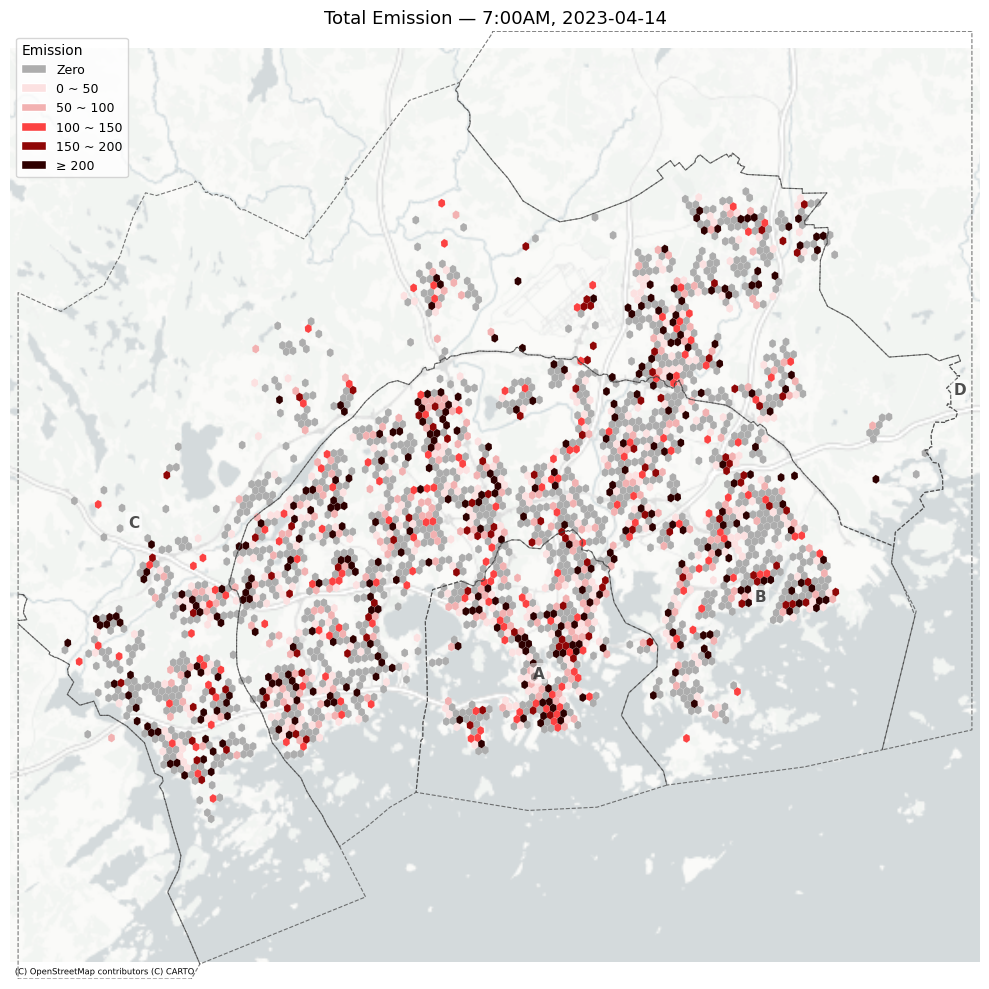

In [40]:
plot_total_single("total_emission_m", "Total Emission — 7:00AM, 2023-04-14")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


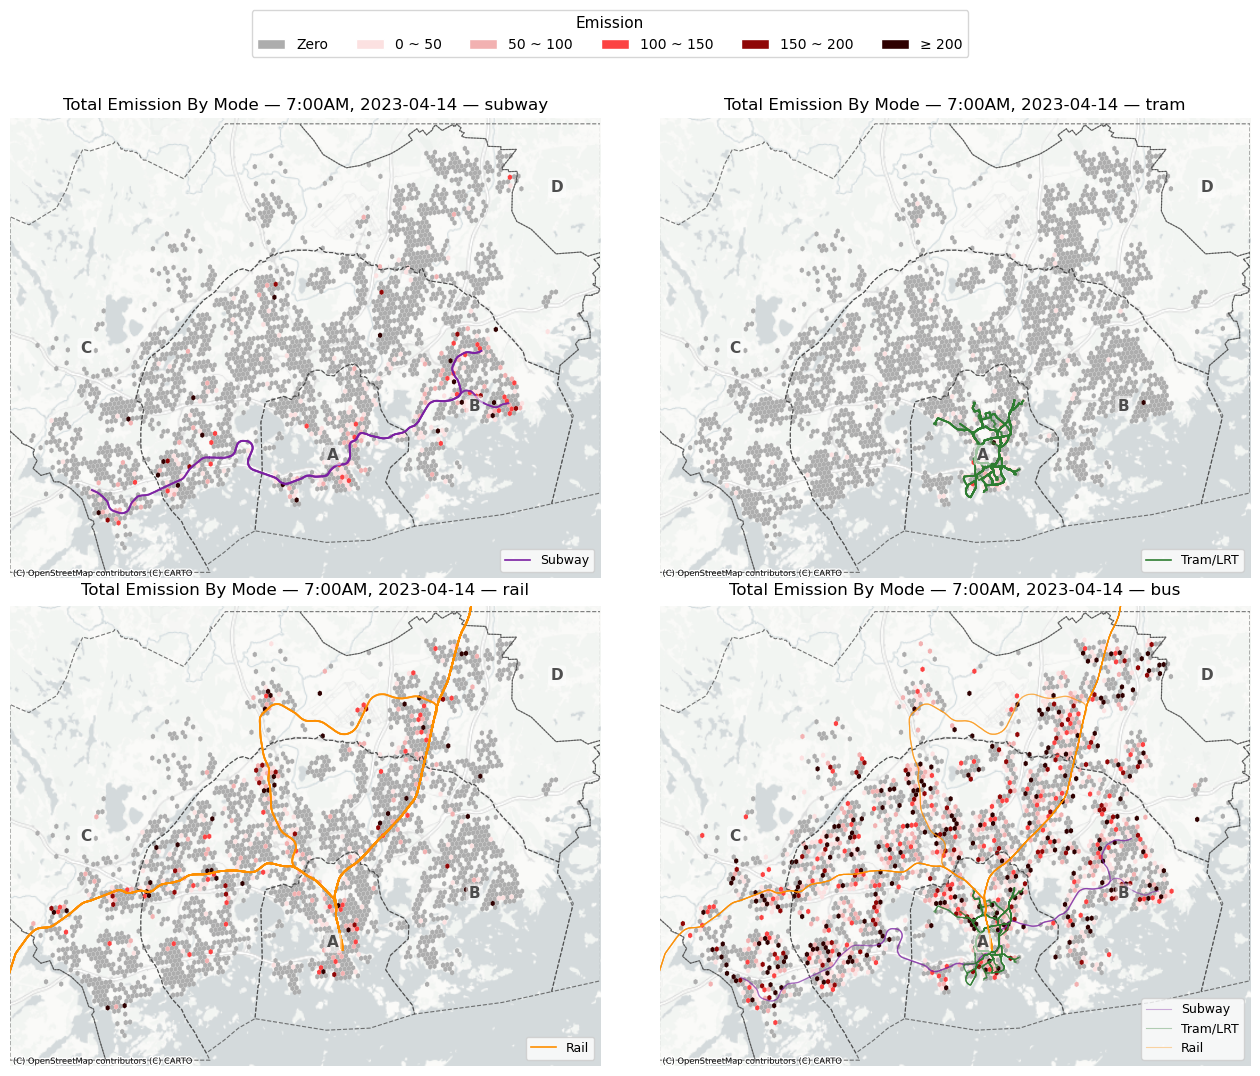

In [41]:
plot_total_by_mode("m", "Total Emission By Mode — 7:00AM, 2023-04-14")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


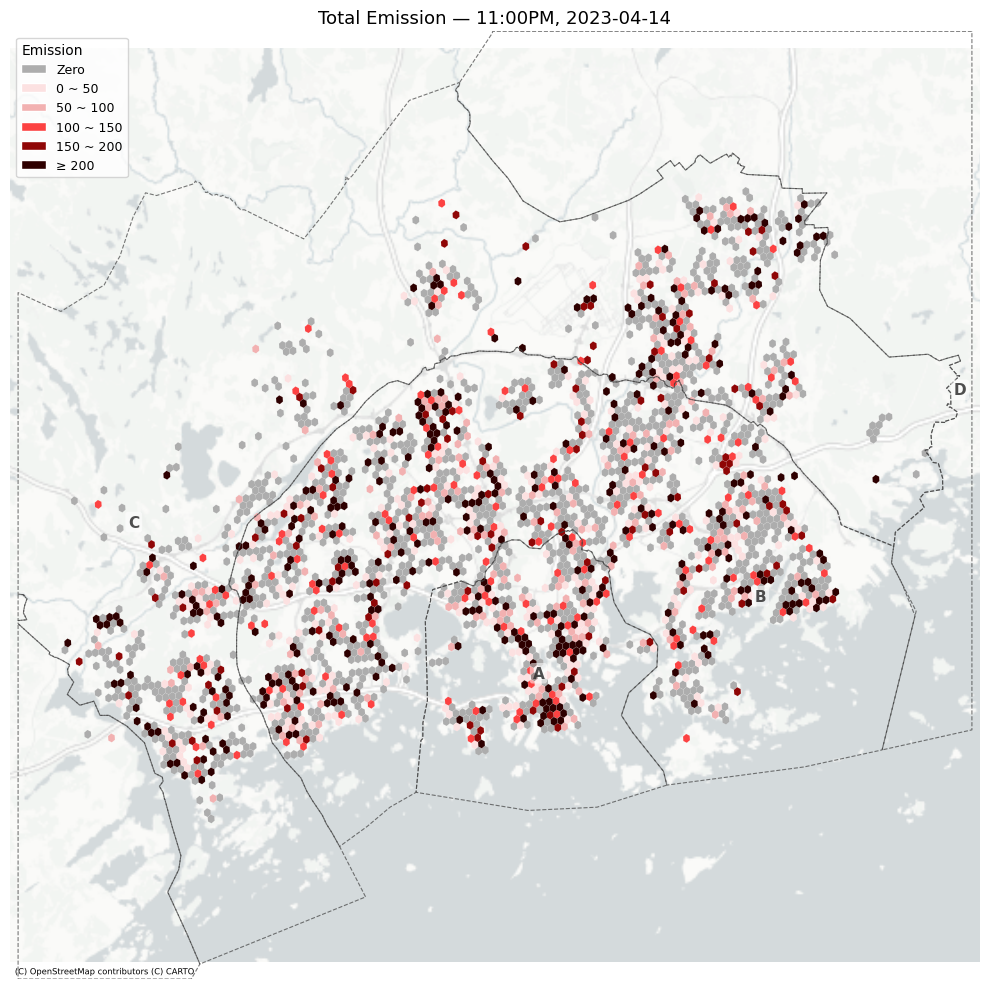

In [42]:
plot_total_single("total_emission_n", "Total Emission — 11:00PM, 2023-04-14")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


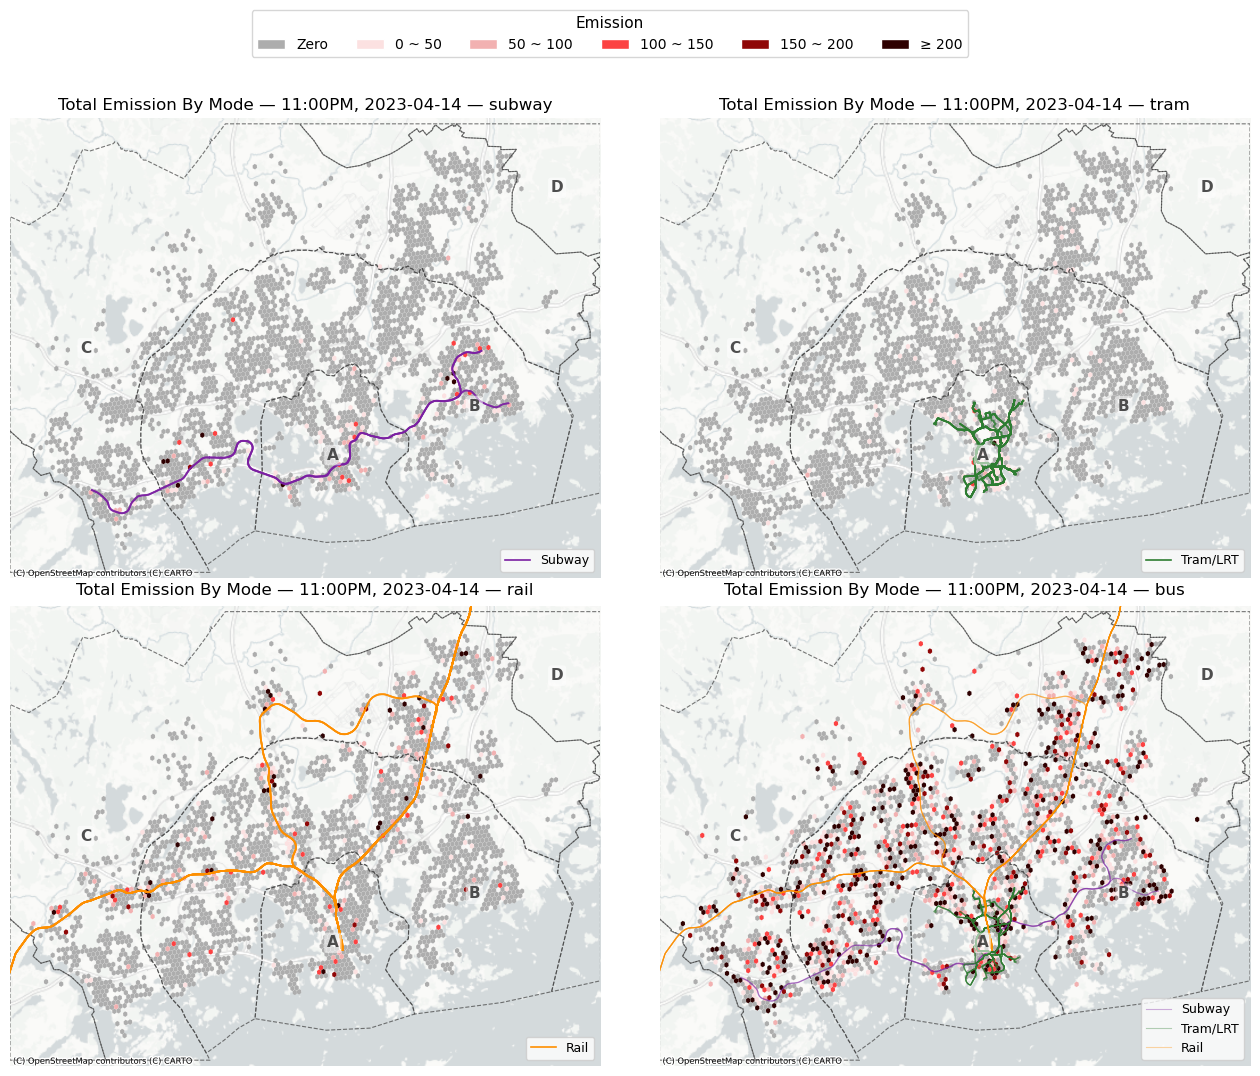

In [43]:
plot_total_by_mode("n", "Total Emission By Mode — 11:00PM, 2023-04-14")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


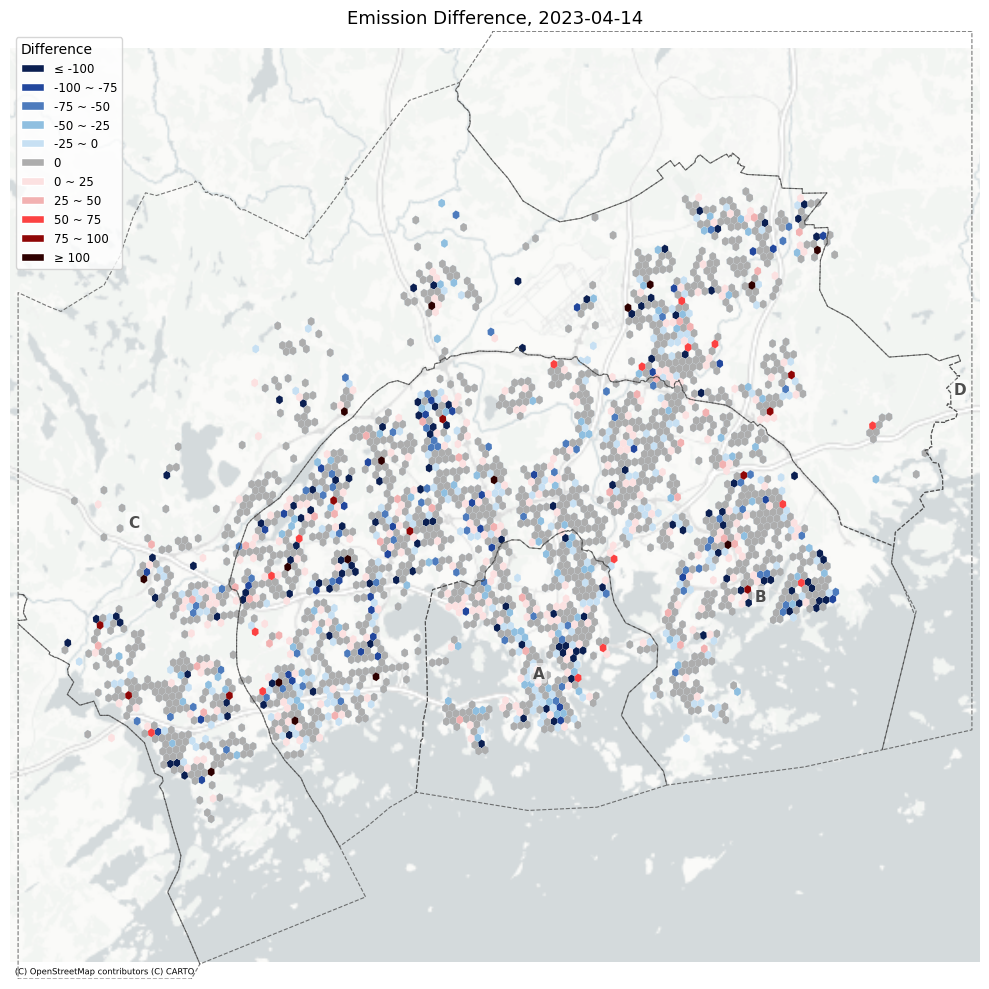

In [44]:
plot_diff_single("emission_diff", "Emission Difference, 2023-04-14")

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


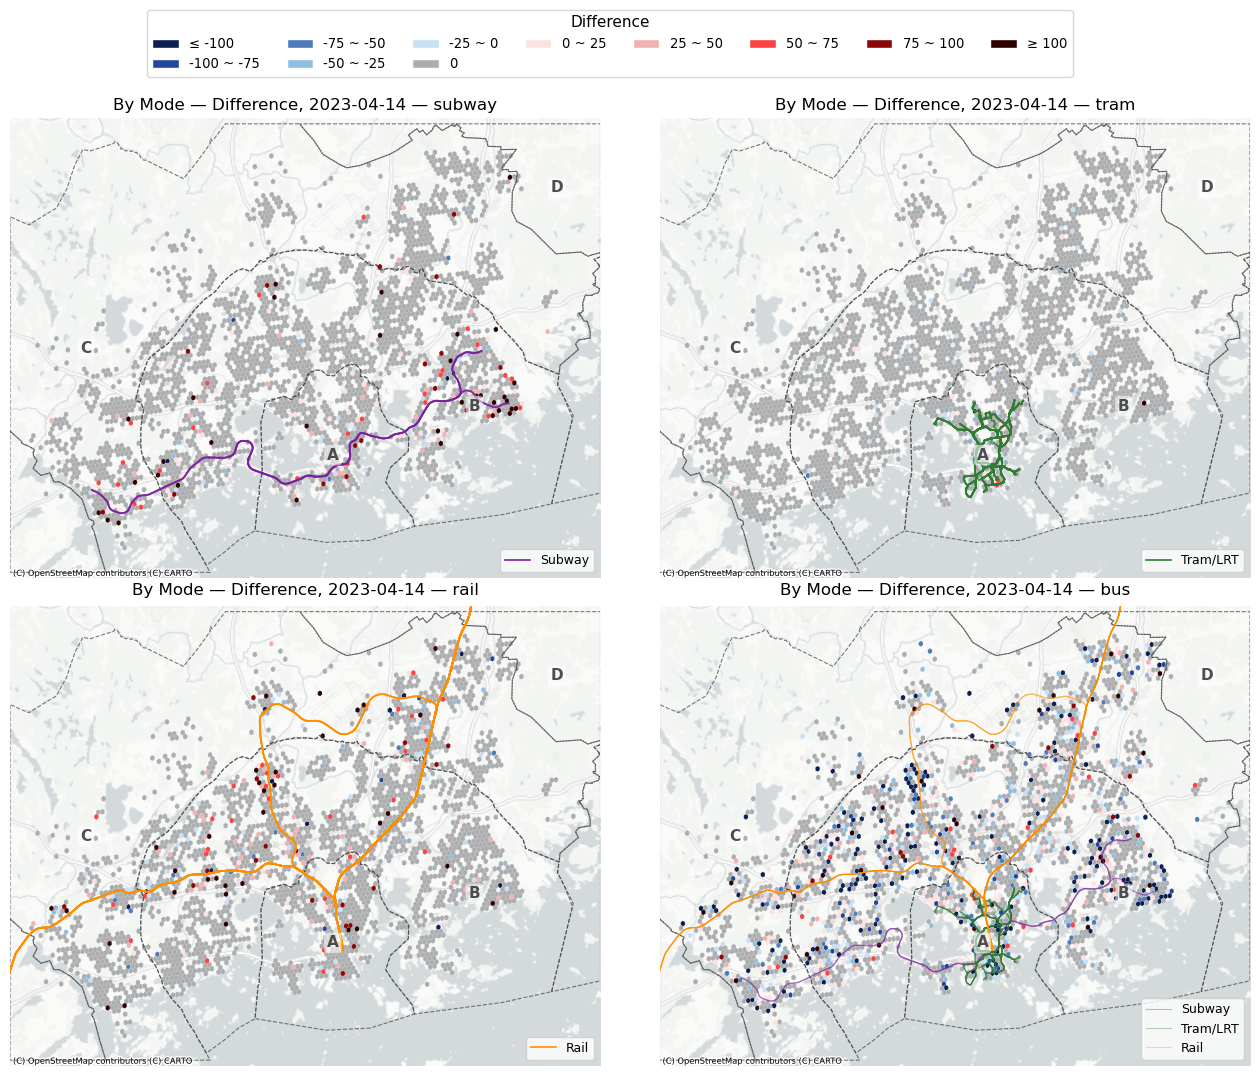

In [45]:
plot_diff_by_mode("By Mode — Difference, 2023-04-14")